# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-109A Introduction to Data Science


## Lab 3: Regularization and Cross-Validation 

**Harvard University**<br/>
**Fall 2019**<br/>
**Authors:** Rahul Dave, David Sondak, Will Claybaugh, Pavlos Protopapas, Chris Tanner, Kevin Rader, Rylan Schaeffer

---

In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

## Table of Contents
<ol start="0">
  <li> Learning Goals </li>
  <li> Review of regularized regression </li>
  <li> Ridge regression with one predictor on a grid </li>
  <li> Ridge regression with polynomial features on a grid</li>
  <li> Cross-validation --- Multiple Estimates </li>
  <li> Cross-validation --- Finding the best regularization parameter </li>
    
</ol>

##### Learning Goals
In this lab, you will work with some noisy data.  You will use  simple linear and ridge regressions to fit linear, high-order polynomial features to the dataset.  You will attempt to figure out what degree polynomial fits the dataset the best and ultimately use cross validation to determine the best polynomial order.  Finally, you will automate the cross validation process using `sklearn` in order to determine the best regularization paramter for the ridge regression analysis on your dataset.

By the end of this lab, you should:
* Really understand regularized regression principles.
* Have a good grasp of working with ridge regression through the `sklearn` API
* Understand the effects of the regularization (a.k.a penalization) parameter on fits from ridge regression
* Understand the ideas behind cross-validation
  * Why is it necessary?
  * Why is it important?
  * Basic implementation details.
* Be able to use `sklearn` objects to automate the cross validation process.

**This lab corresponds to lectures 5 and 6 and maps on to homework 3 (and beyond).**

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

## Part 1:  Review of regularized regression
We briefly review the idea of regularization as introduced in lecture.  Recall that in the ordinary least squares problem we find the regression coefficients $\boldsymbol{\beta}\in\mathbb{R}^{m}$ that minimize the loss function 
\begin{align*}
  L(\boldsymbol{\beta}) = \frac{1}{n} \sum_{i=1}^n \|y_i - \boldsymbol{\beta}^T \mathbf{x}_i\|^2.
\end{align*}
Recall that we have $n$ observations.  Here $y_i$ is the response variable for observation $i$ and $\mathbf{x}_i\in\mathbb{R}^{m}$ is a vector from the predictor matrix corresponding to observation $i$.

The general idea behind regularization is to penalize the loss function to account for possibly very large values of the coefficients $\boldsymbol{\beta}$.  Instead of minimizing $L(\boldsymbol{\beta})$, we minimize the regularized loss function
\begin{align*}
  L_{\text{reg}}(\boldsymbol{\beta}) = L(\boldsymbol{\beta}) + \lambda R(\boldsymbol{\beta})
\end{align*}
where $R(\boldsymbol{\beta})$ is a penalty function and $\lambda$ is a scalar that weighs the relative importance of this penalty.  In this lab we will explore one regularized regression model: `ridge` regression.  In ridge regression, the penalty function is the sum of the squares of the parameters, which is written as
\begin{align*}
  L_{\text{ridge}}(\boldsymbol{\beta}) = \frac{1}{n} \sum_{i=1}^n \|y_i - \boldsymbol{\beta}^T \mathbf{x}_i\|^2 + \lambda \sum_{j=1}^m \beta_{j}^{2}.
\end{align*}

In lecture, you also learned about `LASSO` regression in which the penalty function is the sum of the absolute values of the parameters.  This is written as,
\begin{align*}
  L_{\text{LASSO}}(\boldsymbol{\beta}) = \frac{1}{n} \sum_{i=1}^n \|y_i - \boldsymbol{\beta}^T \mathbf{x}_i\|^2 + \lambda \sum_{j=1}^m |\beta_j|.
\end{align*}

In this lab, we will show how these optimization problems can be solved with `sklearn` to determine the model parameters $\boldsymbol{\beta}$.  We will also show how to choose $\lambda$ appropriately via cross-validation.

### Dataset
You will work with a synthetic dataset contained in `../data/noisypopulation.csv`.  The data were generated from a specific function $f\left(x\right)$ (the actual form will not be revealed to you in this lab).  Noise was added to the function to generate synthetic, noisy observations via $y = f\left(x\right) + \epsilon$ where $\epsilon$ was drawn from a random distribution.  The idea here is that in real life the data you are working with often comes with noise.  Even if you could make observations at every single value of $x$, the true function may still be obscured.  Of course, the samples you actually take are usually a subset of all the possible observations.  In this lab, we will refer to observations at every single value of $x$ as the *population* and the subset of observations as *in-sample y* or simply *the observations*.

The dataset contains three columns: 
1. `f` is the true function value 
2. `x` is the predictor
3. `y` is the measured response.

In [3]:
df=pd.read_csv("../data/noisypopulation.csv")
df.head()

,f,x,y
0,0.047790,0.00,0.011307
1,0.051199,0.01,0.010000
2,0.054799,0.02,0.007237
3,0.058596,0.03,0.000056
4,0.062597,0.04,0.010000


In this lab, we will try out some regression methods to fit the data and see how well our model matches the true function `f`.

In [4]:
# Convert f, x, y to numpy array
f = df.f.values
x = df.x.values
y = df.y.values

df.shape

(200, 3)

Let's take a quick look at the dataset.  We will plot the true function value and the population of data.

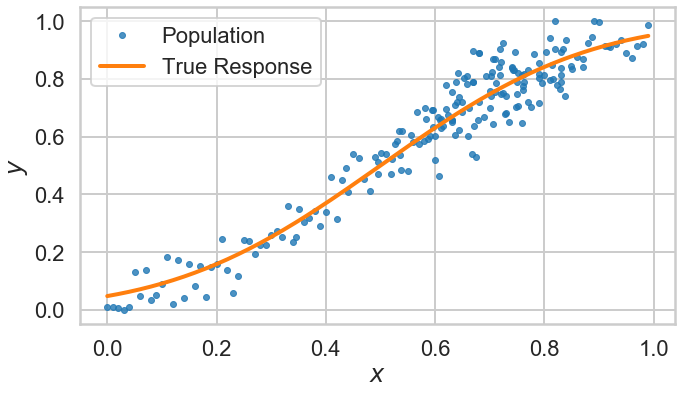

In [5]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.plot(x, y, '.', alpha=0.8, label=r'Population')
ax.plot(x, f, lw=4, label='True Response')

ax.legend(loc='upper left')

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

fig.tight_layout()

It is often the case that you just can't make observations at every single value of $x$.  We will simulate this situation by making a random selection of $60$ points from the full $200$ points.  We do it by choosing the indices randomly and then using these indices as a way of getting the appropriate sample of data.

In [6]:
indexes=np.sort(np.random.choice(x.shape[0], size=60, replace=False)) # Using sort to make plotting easier later
indexes

array([  3,   6,   9,  12,  26,  32,  34,  35,  43,  44,  46,  47,  51,
        52,  67,  75,  84,  86,  89,  92,  94,  96, 103, 106, 107, 109,
       111, 112, 117, 121, 122, 124, 126, 127, 129, 130, 136, 138, 139,
       145, 147, 148, 150, 158, 160, 163, 164, 166, 168, 169, 171, 173,
       176, 188, 189, 190, 193, 195, 198, 199])

Note:  If you are not familiar with the `numpy` `sort` method or the `numpy random.choice()` method, then please take a moment to look them up in the `numpy` documentation.

Moving on, let's get the $60$ random observations from our dataset.

In [7]:
# Create a new dataframe from the random points
sample_df = pd.DataFrame(dict(x=x[indexes],f=f[indexes],y=y[indexes])) # New dataframe
sample_df.head()

,x,f,y
0,0.03,0.058596,0.000056
1,0.06,0.071233,0.048360
2,0.09,0.085865,0.050510
3,0.12,0.102637,0.021021
4,0.26,0.211855,0.239043


Let's take one more look at our data to see which points we've selected.

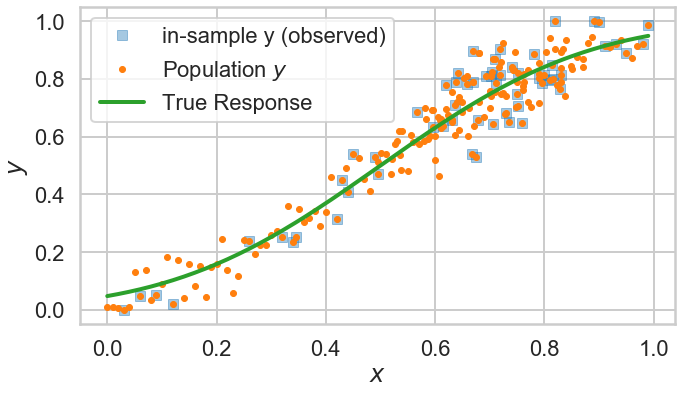

In [8]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(sample_df['x'], sample_df['y'], 's', alpha=0.4, ms=10, label="in-sample y (observed)")
ax.plot(x,y, '.', label=r'Population $y$')
ax.plot(x,f, lw=4, label='True Response')

ax.legend(loc='upper left')

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

fig.tight_layout()

Now we do our favorite thing and split the sample data into training and testing sets.

Note that here we are actually getting indices instead of the actual training and test set.  This is okay and is another way of generating train-test splits (in fact can be prefered for some data wrangling purposes).

In [9]:
from sklearn.model_selection import train_test_split

datasize=sample_df.shape[0]

#split dataset using the index, as we have x, f, and y that we want to split.
itrain, itest = train_test_split(np.arange(60), train_size=0.8)

xtrain = sample_df.x[itrain].values
ftrain = sample_df.f[itrain].values
ytrain = sample_df.y[itrain].values

xtest= sample_df.x[itest].values
ftest = sample_df.f[itest].values
ytest = sample_df.y[itest].values

Great!  At this point we've explored our data a little bit, selected a sample of the dataset, and done a train-test split on the sample dataset.

<hr style='height:2px'>

Let's move on to the data analysis.  We'll begin with ridge regression.  In particular we'll do ridge regression on a single predictor and compare it with simple linear regression.

To start, let's fit the old classic, linear regression.

In [10]:
from sklearn.linear_model import LinearRegression

# fit the model to training data
simp_reg = LinearRegression().fit(xtrain.reshape(-1,1), ytrain)

# save the beta coefficients
beta0_sreg = simp_reg.intercept_
beta1_sreg = simp_reg.coef_[0]

print("(beta0, beta1) = ({0:8.6f}, {1:8.6f})".format(beta0_sreg, beta1_sreg))

(beta0, beta1) = (-0.017506, 1.070039)


But wait! Unlike `statsmodels`, we don't get confidence intervals for the betas. Fortunately, we can bootstrap to build the confidence intervals

<div class="exercise"><b>Exercise 1</b></div>

1. In the code below, two key steps of bootstrapping are missing. Fill in the code to draw sample indices with replacement and to fit the model to the bootstrap sample. You'll need `numpy`'s `np.random.choice`.  Here's the [function documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html) in case you need it.
2. Visualize the results of the 1000 bootstrap resamples, and use `numpy`'s `np.percentile` to estimate a 90\% confidence interval: [function documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.percentile.html).

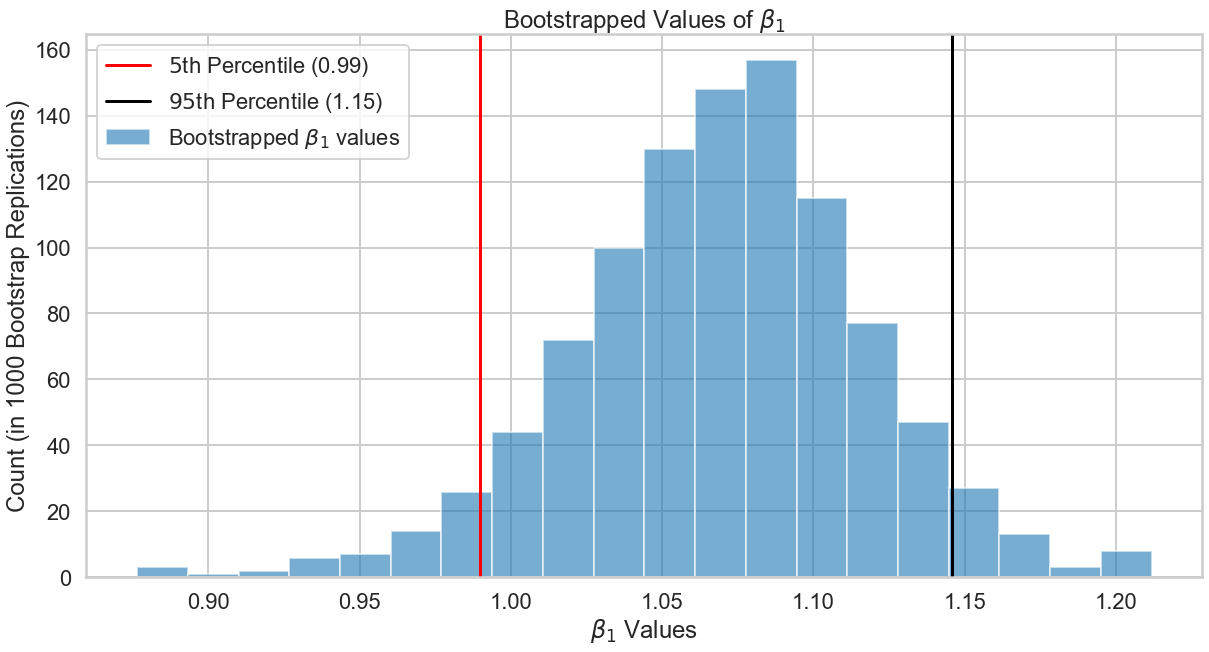

In [11]:
N = 1000
bootstrap_beta1s = np.zeros(N)
for cur_bootstrap_rep in range(N):
    # select indices that are in the resample (easiest way to be sure we grab y values that match the x values)
    inds_to_sample = np.random.choice(xtrain.shape[0], size=xtrain.shape[0], replace=True)
    
    # take the sample
    x_train_resample = xtrain[inds_to_sample]
    y_train_resample = ytrain[inds_to_sample]
    
    # fit the model
    bootstrap_model = LinearRegression().fit(x_train_resample.reshape(-1,1), y_train_resample)
    
    # extract the beta1 and append
    bootstrap_beta1s[cur_bootstrap_rep] = bootstrap_model.coef_[0]

## display the results

# calculate 5th and 95th percentiles
lower_limit, upper_limit = np.percentile(bootstrap_beta1s,[5,95])

# plot histogram and bounds
fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.hist(bootstrap_beta1s, 20, alpha=0.6, label=r"Bootstrapped $\beta_{1}$ values")
ax.axvline(lower_limit, color='red', label=r"$5$th Percentile ({:.2f})".format(lower_limit))
ax.axvline(upper_limit, color='black', label=r"$95$th Percentile ({:.2f})".format(upper_limit))

# good plots have labels
ax.set_xlabel(r"$\beta_{1}$ Values")
ax.set_ylabel("Count (in 1000 Bootstrap Replications)")
plt.title(r"Bootstrapped Values of $\beta_{1}$")
plt.legend();

From the above, we find that the bootstrap $90\%$ confidence interval is well away from $0$. We can confidently say that $\beta_{1}$ is not secretly $0$ (and we're being fooled by randomness).

Next we'll dive into ridge regression!

## Part 2: Ridge regression with one predictor on a grid

To begin, we'll use `sklearn` to do simple linear regression on the sampled training data.  We'll then do ridge regression with the same data, setting the penalty parameter $\lambda$ to zero.  Setting $\lambda = 0$ reduces the ridge problem to the simple ordinary least squares problem, so we expect the results of these models to be identical. 

We will store the regression coefficients in a dataframe for easy comparison.  The cell below provides some code to set up the dataframe ahead of time.  Notice that we don't know the actual values in the `pandas` series, so we just set them to `NaN`.  We will overwrite these later (note, we can create '[expressions](https://matplotlib.org/3.1.1/tutorials/text/mathtext.html)' to use formatted latex in our columns and indices when rendered).

In [12]:
regression_coeffs = dict() # Store regression coefficients from each model in a dictionary

regression_coeffs['OLS'] = [np.nan]*2 # Initialize to null
regression_coeffs[r'Ridge $\lambda = 0$'] = [np.nan]*2

dfResults = pd.DataFrame(regression_coeffs) # Create dataframe

dfResults.rename({0: r'$\beta_{0}$', 1: r'$\beta_{1}$'}, inplace=True) # Rename rows
dfResults

,OLS,Ridge $\lambda = 0$
$\beta_{0}$,NaN,NaN
$\beta_{1}$,NaN,NaN


We start with simple linear regression to get the ball rolling.

In [13]:
simp_reg = LinearRegression() # build the the ordinary least squares model

simp_reg.fit(xtrain.reshape(-1,1), ytrain) # fit the model to training data

# save the beta coefficients
beta0_sreg = simp_reg.intercept_
beta1_sreg = simp_reg.coef_[0]

dfResults['OLS'][:] = [beta0_sreg, beta1_sreg]
dfResults

,OLS,Ridge $\lambda = 0$
$\beta_{0}$,-0.017506,NaN
$\beta_{1}$,1.070039,NaN


In [14]:
y_predict =  beta0_sreg + beta1_sreg*x # make predictions

We will use the above $\boldsymbol\beta$ coefficients as a benchmark for comparision to the ridge method.  The same coefficients can be obtained with ridge regression, which we demonstrate now.

For reference, here is the ridge regression documentation: [sklearn.linear_model.Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html).  

In [15]:
from sklearn.linear_model import Ridge 

The snippet of code below implements the ridge regression with $\lambda = 0$.

**Note:** The weight $\lambda$ is referred to as `alpha` in the documentation.

**Remark:** $\lambda$ goes by many names including, but not limited to: regularization parameter, penalization parameter, shrinking parameter, and weight.  Regardless of these names, it is a hyperparameter.  That is, you set it before you begin the training process.  An algorithm can be very sensitive to its hyperparameters and we will discuss how a method for selecting the "correct" hyperparameter values later in this lab.

In [16]:
ridge_reg = Ridge(alpha = 0) # build the ridge regression model with specified lambda, i.e. alpha

ridge_reg.fit(xtrain.reshape(-1,1), ytrain) # fit the model to training data

# save the beta coefficients
beta0_ridge = ridge_reg.intercept_
beta1_ridge = ridge_reg.coef_[0]

ypredict_ridge = ridge_reg.predict(x.reshape(-1,1)) # make predictions everywhere

dfResults[r'Ridge $\lambda = 0$'][:] = [beta0_ridge, beta1_ridge]
dfResults

,OLS,Ridge $\lambda = 0$
$\beta_{0}$,-0.017506,-0.017506
$\beta_{1}$,1.070039,1.070039


The beta coefficients for linear and ridge regressions coincide for $\lambda = 0$, as expected. We plot the data and fits.

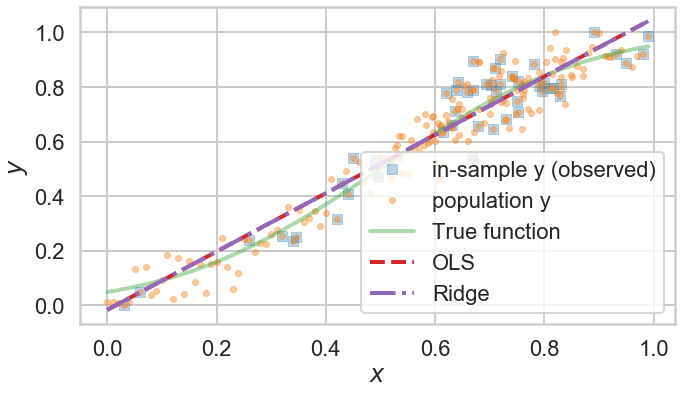

In [17]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.plot(xtrain, ytrain, 's', alpha=0.3, ms=10, label="in-sample y (observed)") # plot in-sample training data
ax.plot(x, y, '.', alpha=0.4, label="population y") # plot population data
ax.plot(x, f, ls='-',  alpha=0.4, lw=4, label="True function")
ax.plot(x, y_predict, ls='--', lw=4, label="OLS") # plot simple linear regression fit
ax.plot(x, ypredict_ridge, ls='-.', lw = 4, label="Ridge") # plot ridge regression fit

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.legend(loc=4);

fig.tight_layout()

<div class="exercise"><b>Exercise 2</b></div>

Explore the effect of $\lambda$ on ridge regression:

1. Make a plot with of the ridge regression predictions with $\lambda = 0, 5, 10, 100$.  Be sure to include a legend.

2. What happens for very large $\lambda$ (e.g. $\lambda \to \infty$)?

Your plot should look something like the following plot (doesn't have to be exact):
![](../img/ridge_lambda.png)

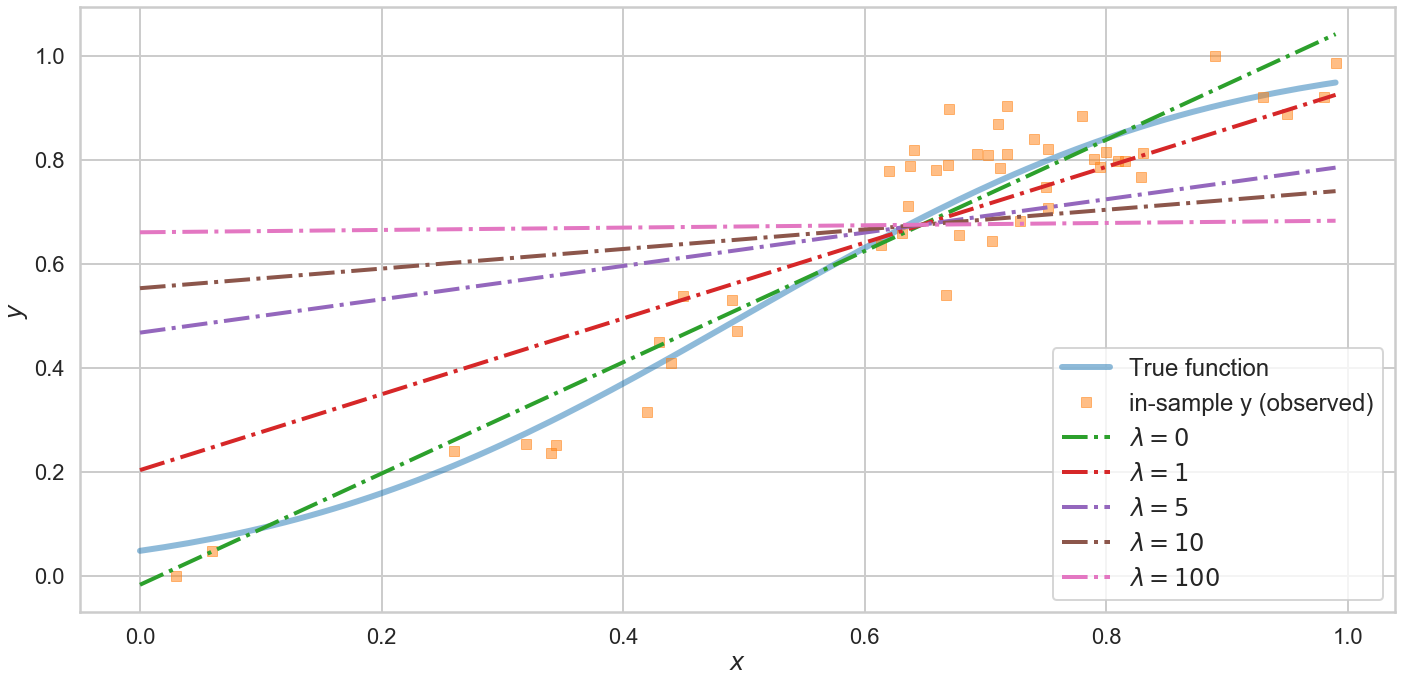

In [18]:
######
# Your code here
######

fig, ax = plt.subplots(1,1, figsize=(20,10))

pen_params = [0, 1, 5, 10, 100]

ax.plot(x, f, ls='-', lw=6, alpha=0.5, label="True function")
ax.plot(xtrain, ytrain, 's', alpha=0.5, ms=10, label="in-sample y (observed)") # plot in-sample training data

for alpha in pen_params:
    ridge_reg = Ridge(alpha = alpha) # build the ridge regression model with specified lambda, i.e. alpha
    ridge_reg.fit(xtrain.reshape(-1,1), ytrain) # fit the model to training data
    ypredict_ridge = ridge_reg.predict(x.reshape(-1,1))
    ax.plot(x, ypredict_ridge, ls='-.', lw = 4, label=r"$\lambda = {}$".format(alpha)) # plot ridge regression fit

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.legend(loc=4, fontsize=24);

fig.tight_layout()

fig.savefig('../img/ridge_lambda.png')

*your answer here*

### Part 2 Recap
That was nice, but we were just doing simple linear regression.  We really want to do more interesting regression problems like multiple regression.  We will do so in the next section.

## Part 3: Ridge regression with polynomial features on a grid

Now we'll make a more complex model by adding polynomial features.  Instead of building the linear model $y = \beta_0 + \beta_1 x$, we build a polynomial model $y = \beta_0 + \beta_1 x + \beta_2 x^2 + \ldots \beta_d x^d$ for some $d$ to be determined.  This regression will be linear though, since we'll be treating  $x^2, \ldots, x^d$ themselves as predictors in the linear model.

The design matrix $\mathbf{X}$ contains columns corresponding to $1, x, x^2, \ldots, x^d$. To build it, we use `sklearn`. (The particular design matrix is also known as the [*Vandermonde* matrix](https://en.wikipedia.org/wiki/Vandermonde_matrix)).  For example, if we have three observations<br><br>
\begin{align*}
  \left\{\left(x_{1}, y_{1}\right), \left(x_{2}, y_{2}\right), \left(x_{3}, y_{3}\right)\right\}
\end{align*}<br>
and we want polynomial features up to and including degree $4$, the design matrix looks like<br><br>
\begin{align*}
X = \begin{bmatrix}
x_1^0 & x_1^1 & x_1^2 & x_1^3 & x_1^4\\
x_2^0 & x_2^1 & x_2^2 & x_2^3 & x_2^4\\
x_3^0 & x_3^1 & x_3^2 & x_3^3 & x_3^4\\
\end{bmatrix} = 
\begin{bmatrix}
1& x_1^1 & x_1^2 & x_1^3 & x_1^4\\
1 & x_2^1 & x_2^2 & x_2^3 & x_2^4\\
1 & x_3^1 & x_3^2 & x_3^3 & x_3^4\\
\end{bmatrix}.
\end{align*}

<div class="exercise"><b>Exercise 3</b></div>

1. Make a toy vector called `toy`, where  
\begin{align*}
  \mathrm{toy} = 
  \begin{bmatrix}
    0 \\
    2 \\
    5 \\
  \end{bmatrix}. 
\end{align*}
2. Build the feature matrix up to (and including) degree $4$. Confirm that the entries in the matrix are what you'd expect based on the above discussion.

**Note:** You should try to use `sklearn` to build the matrix with `PolynomialFeatures()`.

In [19]:
from sklearn.preprocessing import PolynomialFeatures

In [20]:
######
# your code here
######


toy = np.array([0, 2, 5])
PolynomialFeatures(4).fit_transform(toy.reshape(-1,1))

array([[  1.,   0.,   0.,   0.,   0.],
       [  1.,   2.,   4.,   8.,  16.],
       [  1.,   5.,  25., 125., 625.]])

We now continue working with our data.  We write a function to make polynomial features of given degrees and we store the features in a dictionary. 

<div class="exercise"><b>Exercise 4</b></div>

The code provided below is missing a few lines and it's missing many comments.  Do the following:
1. Comment every line of the code
   * Normally, you won't do such excessive commenting.  In this case, we want to make sure you understand every single line since you didn't actually write this code.
2. Fill in the missing lines
   * Create a ridge regression object at each $\lambda$ value in the list
   * Perform the ridge regression using the `fit` method from the newly created ridge regression object
   * Make a prediction on the grid and store the results in `ypredict_ridge`.

**Note:** We're not giving you an example figure here since we gave you most of the code.

**Warning!** Make sure you understand the entire code!  There are many nice things in there.

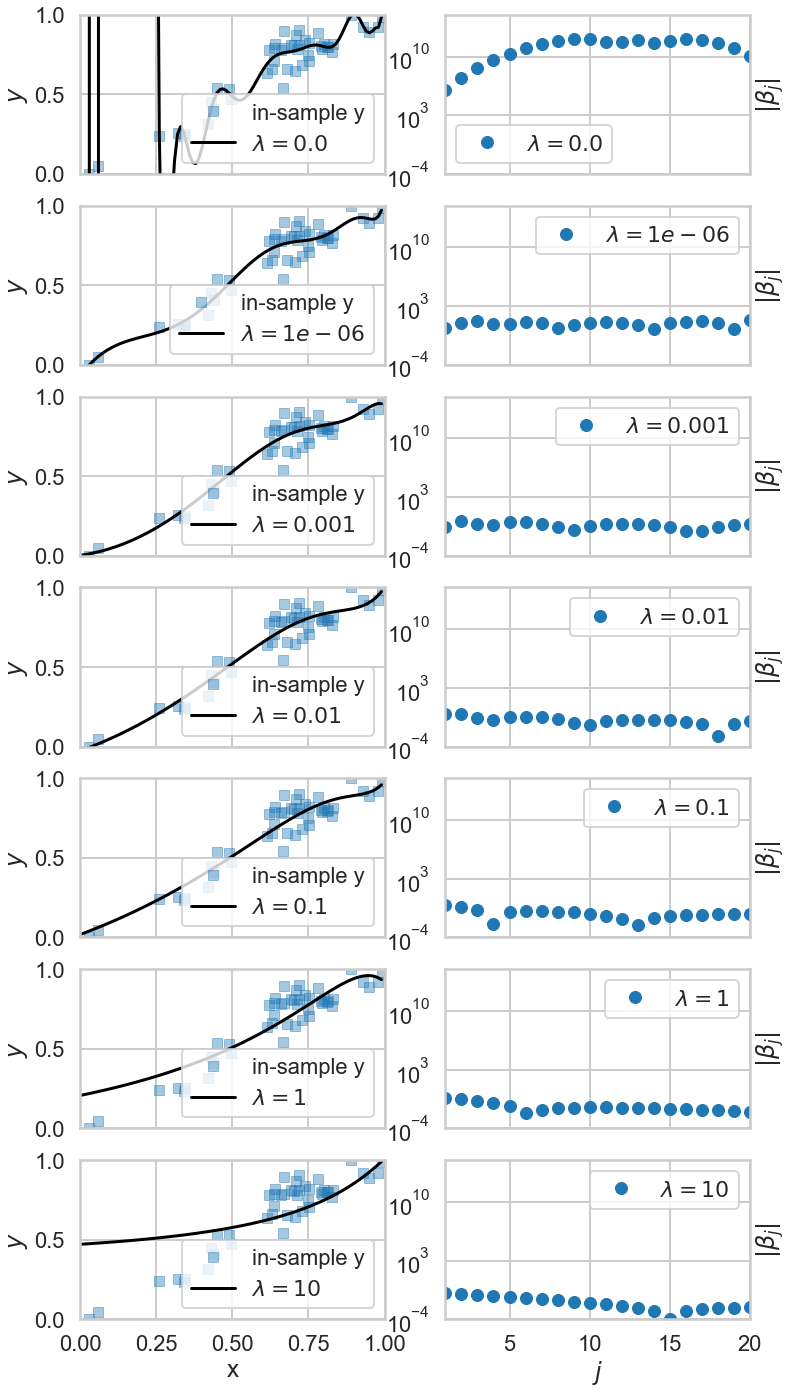

In [21]:
d = 20 # Maximum polynomial degree
# You will create a grid of plots of this size (7 rows x 2 columns)
rows = 7
cols = 2
lambdas = [0., 1e-6, 1e-3, 1e-2, 1e-1, 1, 10] # Various penalization parameters to try
grid_to_predict = np.arange(0, 1, .01) # Predictions will be made on this grid

# Create training set and test set
Xtrain = PolynomialFeatures(d).fit_transform(xtrain.reshape(-1,1))
test_set = PolynomialFeatures(d).fit_transform(grid_to_predict.reshape(-1,1))

fig, axs = plt.subplots(rows, cols, sharex='col', figsize=(12, 24)) # Set up plotting objects

for i, lam in enumerate(lambdas):
    ######
    # your code here
    ######
    ridge_reg = Ridge(alpha = lam) # Create regression object
    ridge_reg.fit(Xtrain, ytrain) # Fit on regression object
    ypredict_ridge = ridge_reg.predict(test_set) # Do a prediction on the test set
    
    ### Provided code
    axs[i,0].plot(xtrain, ytrain, 's', alpha=0.4, ms=10, label="in-sample y") # Plot sample observations
    axs[i,0].plot(grid_to_predict, ypredict_ridge, 'k-', label=r"$\lambda =  {0}$".format(lam)) # Ridge regression prediction
    axs[i,0].set_ylabel('$y$') # y axis label
    axs[i,0].set_ylim((0, 1)) # y axis limits
    axs[i,0].set_xlim((0, 1)) # x axis limits
    axs[i,0].legend(loc='best') # legend
    
    coef = ridge_reg.coef_.ravel() # Unpack the coefficients from the regression
    
    axs[i,1].semilogy(np.abs(coef), ls=' ', marker='o', label=r"$\lambda =  {0}$".format(lam)) # plot coefficients
    axs[i,1].set_ylim((1e-04, 1e+15)) # Set y axis limits
    axs[i,1].set_xlim(1, 20) # Set y axis limits
    axs[i,1].yaxis.set_label_position("right") # Move y-axis label to right
    axs[i,1].set_ylabel(r'$\left|\beta_{j}\right|$') # Label y-axis
    axs[i,1].legend(loc='best') # Legend

# Label x axes
axs[-1, 0].set_xlabel("x")
axs[-1, 1].set_xlabel(r"$j$");

As you can see, as we increase $\lambda$ from 0 to 1, we start out owith extreme verfitting, then the models do quite well, and then the fits develop a mind of their own irrespective of data, as the penalty term dominates.

<div class="exercise"><b>Exercise 5</b></div>

1. What would you expect if you compared a performance metric between these models on a grid?


*your answer here*

### Part 3 Recap
We did a multiple ridge regression on our dataset where the features were monomials from a high-order polynomial.  We also assessed the impact of the regularization parameter on the solution.  

Now we're going to go back to unregularized linear regression for the moment to illustrate some of the ideas behind cross validation.  In particular, we will use unregularized linear regression models where our feature is a polynomial of a particular order.  We would like to determine what order polynomial best fits our dataset.

## Part 4:  Cross-validation --- Multiple Estimates
Now we've done a ridge regression with polynomial features.  We've explored the effects of different penalization parameters on the solution.  The polynomial order and penalization parameter are called hyperparameters.  It would be nice to know what the best choice of $d$ and $\lambda$ are.

In this section, we will begin exploring how to find the best polynomial degree, but we'll do so in the context of unregularized linear regression.  This will naturally lead into a discussion of cross validation.

In [22]:
from sklearn.metrics import mean_squared_error

### Doing the fit
First, we will create models using all polynomial features up to a maximum degree $d$.  We will compute the MSE for each of these models and use the minimum MSE on the test set as an indicator of which polynomial order is the best.

In [23]:
d = 20 # Maximum polynomial degree
degrees = range(0,d+1)

In [24]:
# Allocate arrays for storing error
error_train=np.empty(d+1)
error_test=np.empty(d+1)

<div class="exercise"><b>Exercise 6</b></div>
* For each degree $d$, train on the training set and predict on the test set.
* Store the training MSE in `error_train` and test MSE in `error_test`.

**Note:** We have provided some starter code for you to fill in.

In [25]:
# for each degree, we now fit on the training set and predict on the test set
# we accumulate the MSE on both sets in error_train and error_test
for d in degrees: # for increasing polynomial degrees 0,1,2...
    Xtrain = PolynomialFeatures(d).fit_transform(xtrain.reshape(-1,1))
    Xtest = PolynomialFeatures(d).fit_transform(xtest.reshape(-1,1))

    est = LinearRegression() # set up model
    est.fit(Xtrain, ytrain) # fit
    # predict
    ######
    # your code here
    ######
    prediction_on_training = est.predict(Xtrain)
    prediction_on_test = est.predict(Xtest)
    # calculate mean squared error
    error_train[d] = mean_squared_error(ytrain, prediction_on_training)
    error_test[d] = mean_squared_error(ytest, prediction_on_test)

The best degree is:

In [26]:
bestd = np.argmin(error_test)
print("Best polynomial order is {0}.".format(bestd))

Best polynomial order is 1.


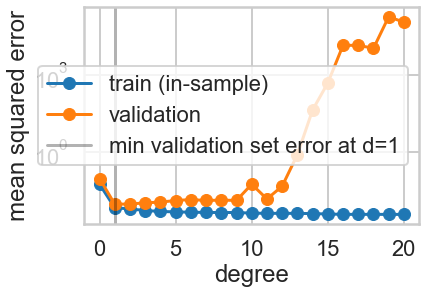

In [27]:
plt.plot(degrees, error_train, marker='o', label='train (in-sample)')
plt.plot(degrees, error_test, marker='o', label='validation')
plt.axvline(bestd, 0,10, color='k', label="min validation set error at d={0}".format(bestd), alpha=0.3)
plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='best')
plt.yscale("log")

Remember the complexity-error plot.
![m:caption](../img/complexity-error-plot.png)
Our plot resembles this pattern.  Notice that for $d$ larger than our value, we enter the overfitting regime.  The best $d$ is at the minimum of the error.

## Cross Validation
At this point, if you're in or watching the lab, there is someone whose validation set told them that degree $10$ or $13$ or similar was the best model (it isn't). Can we do something to hedge against this risk? Is there a procedure that brings the class-wide results closer together, so that we each face less risk of picking a poor-but-lucky model?

We could increase the size of the validation set, certainly, but that would take away from the data we have to train on. Instead, cross validation helps make more effecient use of the training data itself.

The idea is illustrated in the figure below:

![m:caption](../img/train-cv2_simple.png)

In fold 1, we fit each candidate model on the data in sections 1,2, and 3, and score each model on the unseen data in section 4 (highlighted). In the next fold, we fit each candidate model on sections 1,3, and 4, and score each model on the unseen data in section 2. 

At the end of the process, we have 4 estimates of how well each model will perform on unseen data. We can average these estimates to get an overall measure of how well each model will do on unseen data. We can also examine the spread of scores a given model recieved.

Importantly, we kept the test set completely separate. Only one, final model is ever tested on the test set.

**Technical notes**: 
1. The four cross-validation estimates are slightly correlated. As a result, there are diminishing returns to increasing the number of folds. (We might naively think that if averaging 4 estimates is good, averaging 50 estimates would be great.)
2. We need the test set because the model that performed best in cross validation isn't quite as good as its average CV score would indicate (it might have gotten slightly lucky scores). To check, we score our final champion against the test set.

### 4-fold CV on our data set

Let us now do 4-fold cross-validation on our  data set. We increase the complexity from degree 0 to degree 20. In each case we take the old training set, split it 4 ways into 4 folds, train on 3 folds, and calculate the validation error on the remaining one. We then average the erros over the four folds to get a cross-validation error for that $d$. Then we do what we did before: find the model with the lowest cross-validation error, and refit it using the entire training set. We can then use the test set to estimate $E_{out}$.

We will use `KFold` from `scikit-learn`:

In [28]:
from sklearn.model_selection import KFold
n_folds = 4 
kfold = KFold(n_folds)
list(kfold.split(range(48)))

[(array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
         29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
         46, 47]),
  array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 24, 25, 26, 27, 28,
         29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
         46, 47]),
  array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
         46, 47]),
  array([24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35]),
  array([36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]))]

What is wrong with the above? Why must we do the below?

In [29]:
kfold = KFold(n_folds, shuffle=True)
list(kfold.split(range(48)))

[(array([ 0,  1,  2,  4,  5,  7,  8,  9, 10, 11, 13, 14, 15, 17, 18, 19, 20,
         21, 23, 24, 25, 26, 27, 28, 29, 30, 32, 35, 36, 37, 39, 41, 42, 44,
         46, 47]),
  array([ 3,  6, 12, 16, 22, 31, 33, 34, 38, 40, 43, 45])),
 (array([ 0,  2,  3,  4,  6,  7,  8,  9, 10, 12, 13, 15, 16, 17, 18, 19, 20,
         21, 22, 24, 27, 28, 30, 31, 32, 33, 34, 37, 38, 39, 40, 41, 42, 43,
         45, 46]),
  array([ 1,  5, 11, 14, 23, 25, 26, 29, 35, 36, 44, 47])),
 (array([ 0,  1,  3,  4,  5,  6,  7,  9, 11, 12, 14, 16, 17, 20, 22, 23, 24,
         25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 40, 41, 43, 44,
         45, 47]),
  array([ 2,  8, 10, 13, 15, 18, 19, 21, 32, 39, 42, 46])),
 (array([ 1,  2,  3,  5,  6,  8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 21, 22,
         23, 25, 26, 29, 31, 32, 33, 34, 35, 36, 38, 39, 40, 42, 43, 44, 45,
         46, 47]),
  array([ 0,  4,  7,  9, 17, 20, 24, 27, 28, 30, 37, 41]))]

<div class="exercise"><b>Exercise 7</b></div>

In this exercise, you will carry out $4$-fold validation.  We have provided you with some skeleton code that does the following:
* Loops over the folds
* At each fold, generate the training and validation sets
* At each fold, loop through the polynomial degrees
* At each fold, and for each polynomial degree, call a function that returns the training and validation errors using the MSE.
* Store the MSEs, for each degree and each fold, in `train_errors` and `valid_errors`.


Here's what you need to do:

1. Write the function (called `compute_MSE`) that returns the training and validation error

Your function should take in `Xtrain` and `Xvalid` at each value of `d`.  It should also accept `Ytrain` and `Yvalid` from the current fold.  The function must create a `LinearRegression` object, fit using that object, and predict on the training and validation using the result from the fit.  Then the function should calculate the MSE on both the training and validiation predictions.

In [30]:
# Set up problem size
d = 20
n_folds = 4
degrees = range(d+1)
train_errors = np.zeros((d+1, n_folds))
valid_errors = np.zeros((d+1, n_folds))

In [31]:
# Your function will go here
def compute_MSE(Xtrain, Ytrain, Xvalid, Yvalid):
    ######
    # your code here
    ######
    
    # Create LinearRegression object
    est = LinearRegression()    
    # Fit using the training data
    est.fit(Xtrain, Ytrain)
    # Make predictions using the training data and the validation data
    Ytrain_pred = est.predict(Xtrain)
    Ytrain_valid = est.predict(Xvalid)
    # Compute MSE
    train_MSE = mean_squared_error(Ytrain, Ytrain_pred)
    valid_MSE = mean_squared_error(Yvalid, Ytrain_valid)
    
    return train_MSE, valid_MSE

Now let's try to run things and see what we get.

In [32]:
# Calculate MSE
fold = 0
for train, valid in KFold(n_folds, shuffle=True).split(range(48)): # split data into train/test groups, 4 times
    for d in degrees:
        train_set = PolynomialFeatures(d).fit_transform(xtrain[train].reshape(-1,1))
        valid_set = PolynomialFeatures(d).fit_transform(xtrain[valid].reshape(-1,1))
        # Compute MSE at each degree and each fold
        train_errors[d, fold], valid_errors[d, fold] = compute_MSE(train_set, ytrain[train], valid_set, ytrain[valid])
    fold += 1

Now we have our errors.  We average the MSEs over the folds.

In [33]:
mean_train_errors = train_errors.mean(axis=1)
mean_valid_errors = valid_errors.mean(axis=1)
std_train_errors = train_errors.std(axis=1)
std_valid_errors = valid_errors.std(axis=1)

Next, we can find the degree that minimizes the `cross-validation` error and, just like before, refit the model on the entire training set.

The polynomial that best fits the data has degree 3.


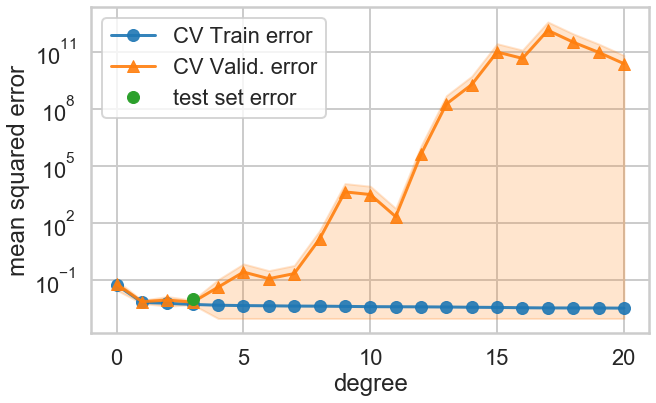

In [47]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

mindeg = np.argmin(mean_valid_errors)
print("The polynomial that best fits the data has degree {0}.".format(mindeg))

post_cv_train = PolynomialFeatures(mindeg).fit_transform(xtrain.reshape(-1,1)) # Training features from best polynomial
post_cv_test = PolynomialFeatures(mindeg).fit_transform(xtest.reshape(-1,1)) # Test features from best polynomial

# fit on whole training set now
est = LinearRegression() # regression object
est.fit(post_cv_train, ytrain) # fit

pred_train = est.predict(post_cv_train) # predict on training set
pred = est.predict(post_cv_test) # predict on test set

errtr = mean_squared_error(ytrain, pred_train) # Train MSE
err = mean_squared_error(pred, ytest) # Test MSE

# Now make plots
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]

plt.plot(degrees, mean_train_errors, marker='o', label='CV Train error', alpha=0.9)
plt.plot(degrees, mean_valid_errors, marker='^', label='CV Valid. error', alpha=0.9)

# Try to represent the errors
plt.fill_between(degrees, (mean_valid_errors-std_valid_errors).clip(min=0.001), (mean_valid_errors+std_valid_errors), color=c1, alpha=0.2)


plt.plot([mindeg], [err], 'o',  label='test set error')

plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='best')
plt.yscale("log")

### Recap
That was a lot of stuff!  Basically, we went back to unregularized linear regression.  We didn't know what polynomial fit the data the best, so we tried various techniques to get the best polynomial degree.  This ultimately led us to the idea of cross validation.

Now we will return to the ridge regularization problem that we were looking at before we got into that whole cross validation business.  Of course, we're pretty sure by now that a third degree polynomial will fit the data the best.

However, we don't really have a good sense of what the penalization parameter $\lambda$ should be in the ridge regression case.  Let's do some cross validation to figure that out.

Don't worry!  Things are actually going to be a lot less tedious this time.

## Part 5: Cross-validation --- Finding the best penalization parameter
Let's use cross-validation to determine the critical value of $\lambda$, which we'll refer to as $\lambda^*$. To do this we use the concept of a *meta-estimator* from `scikit-learn`.

Model selection is supported by two distinct meta-estimators:
1. `GridSearchCV`
2. `RandomizedSearchCV`
The input to these meta-estimators is an estimator, which has some hyperparameters (e.g. $\lambda$) that need to be optimized, and a set of hyperparameter settings to search through.

The concept of a meta-estimator allows us to wrap, for example, cross-validation, or methods that build and combine simpler models or schemes. For example:
```python
    est = Ridge()
    parameters = {"alpha": [1e-8, 1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0]}
    gridclassifier = GridSearchCV(est, param_grid=parameters, cv=4, scoring="neg_mean_squared_error")
```
The `GridSearchCV` replaces the manual iteration over the folds using `KFolds` and the averaging we just did, doing it all for us. It takes a hyperparameter grid in the shape of a dictionary as input, and sets $\lambda$ to the values you want to try, one by one. It then trains the model using cross-validation, and gets the error for each value of the hyperparameter $\lambda$. Finally it compares the errors for the different $\lambda$'s, and picks the best choice model.

Here is a helper function that we will use to get the best Ridge regression.

In [35]:
from sklearn.model_selection import GridSearchCV
def cv_optimize_ridge(x: np.ndarray, y: np.ndarray, list_of_lambdas: list, n_folds: int =4):
    est = Ridge()
    parameters = {'alpha': list_of_lambdas}
    # the scoring parameter below is the default one in ridge, but you can use a different one
    # in the cross-validation phase if you want.
    gs = GridSearchCV(est, param_grid=parameters, cv=n_folds, scoring="neg_mean_squared_error")
    gs.fit(x, y)
    return gs

<div class="exercise"><b>Exercise 8</b></div>

1. Use the function above to fit the model on the training set with $4$-fold cross validation.  Save the fit as the variable `fitmodel`.

In [36]:
lams = [1e-8, 1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0]
######
# your code here
######
fitmodel = cv_optimize_ridge(Xtrain, ytrain, lams, n_folds=4)

In [37]:
print(fitmodel.best_estimator_, "\n")
print(fitmodel.best_params_, "\n")
print(fitmodel.best_score_, "\n")

Ridge(alpha=1e-08, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001) 

{'alpha': 1e-08} 

-0.005497452494755062 



We also output the mean cross-validation error at different $\lambda$ (with a negative sign, as scikit-learn likes to maximize negative error which is equivalent to minimizing error).

In [38]:
fitmodel.cv_results_

{'mean_fit_time': array([0.00068396, 0.0004167 , 0.00041753, 0.00041705, 0.00043499,
        0.00041014, 0.00039917, 0.00064844, 0.00046653, 0.00076813,
        0.00053501]),
 'std_fit_time': array([1.97594162e-04, 3.44007111e-06, 1.49951593e-05, 1.08648984e-05,
        2.10960029e-05, 5.12842465e-06, 2.14162400e-06, 2.78416065e-04,
        2.72060437e-05, 2.93294120e-04, 2.83843301e-05]),
 'mean_score_time': array([0.00033796, 0.00025487, 0.00026959, 0.00025779, 0.00026375,
        0.00025189, 0.00024527, 0.00029099, 0.0002805 , 0.00050098,
        0.00029427]),
 'std_score_time': array([5.05336320e-05, 1.51728655e-06, 3.49864033e-05, 9.78151993e-06,
        1.58967945e-05, 3.13364015e-06, 1.50198974e-06, 2.68226200e-05,
        1.92296815e-05, 2.67197159e-04, 1.66700243e-05]),
 'param_alpha': masked_array(data=[1e-08, 1e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001,
                    0.01, 0.1, 1.0, 10.0],
              mask=[False, False, False, False, False, False, False, False,
     

In [39]:
fit_lambdas = [d['alpha'] for d in fitmodel.cv_results_['params']]
fit_scores = fitmodel.cv_results_['mean_test_score']

Now we make a `log-log` plot of `-fit_scores` versus `fit_lambdas`.

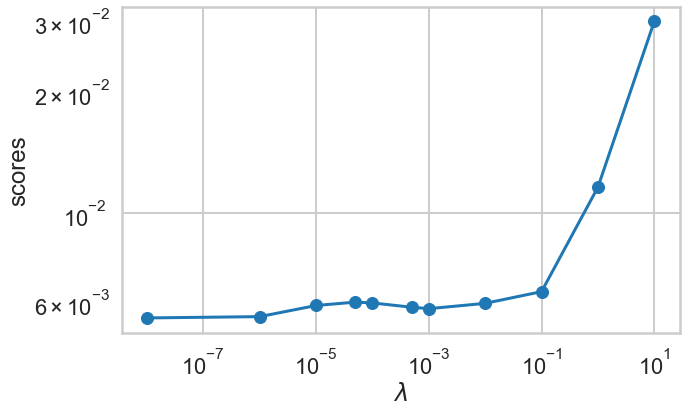

In [40]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(fit_lambdas, -fit_scores, ls='-', marker='o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$\lambda$')
ax.set_ylabel('scores');

### SK-learn's `cross_val_score`: Easier Cross Validation
`GridSearchCV` is an important tool when you are searching over many hyperparameters (and believe us, you will be), but when you only need to get CV scores for a particular model, some students find `cross_val_score` more intuitive.

In [41]:
from sklearn.model_selection import cross_val_score

lr_object =  Ridge(alpha=0)
cross_val_score(lr_object, Xtrain, ytrain, cv=5)

array([-1.03442325e+10, -3.46098864e+02, -2.28707299e+13,  5.64739651e-01,
       -1.62957764e+01])

We can loop over particular models and get scores for each (equivalent to GridSearchCV over the given parameter settings).

In [42]:
for cur_alpha in [1e-8, 1e-4, 1e-2, 1.0, 10.0]:
    lr_object =  Ridge(alpha=cur_alpha)
    scores = cross_val_score(lr_object, Xtrain, ytrain, cv=5)
    print("lambda {0}\t R^2 scores: {1}\t Mean R^2: {2}".format(cur_alpha,scores,np.mean(scores)))

lambda 1e-08	 R^2 scores: [0.87518885 0.77648436 0.76699354 0.90350288 0.75806068]	 Mean R^2: 0.8160460610171121
lambda 0.0001	 R^2 scores: [0.85917738 0.75552144 0.91758701 0.8925804  0.84526072]	 Mean R^2: 0.8540253896180097
lambda 0.01	 R^2 scores: [0.89451479 0.70292393 0.93347904 0.87644175 0.7994571 ]	 Mean R^2: 0.8413633216916608
lambda 1.0	 R^2 scores: [0.79032349 0.48154984 0.73252133 0.84605113 0.54817005]	 Mean R^2: 0.67972316868467
lambda 10.0	 R^2 scores: [0.46744802 0.26050656 0.22556717 0.5120818  0.20454757]	 Mean R^2: 0.33403022567930846


### Built-in Cross Validation: `RidgeCV` and `LassoCV`
Some sklearn models have built-in, automated cross validation to tune their hyper parameters. 

In [43]:
from sklearn.linear_model import RidgeCV

ridgeCV_object = RidgeCV(alphas=(1e-8, 1e-4, 1e-2, 1.0, 10.0), cv=5)
ridgeCV_object.fit(Xtrain, ytrain)
print("Best model searched:\nalpha = {}\nintercept = {}\nbetas = {}, ".format(ridgeCV_object.alpha_,
                                                                            ridgeCV_object.intercept_,
                                                                            ridgeCV_object.coef_
                                                                            )
     )

Best model searched:
alpha = 0.0001
intercept = 0.014747158634293767
betas = [ 0.          0.17097666  1.35873618  1.61316583 -0.36440858 -1.72546587
 -1.81119425 -1.06730695 -0.08614085  0.72771378  1.19017593  1.27782544
  1.06002366  0.64748393  0.15941599 -0.29490877 -0.62490322 -0.76145841
 -0.65636842 -0.28004743  0.38144976], 


### Important note: 

1. For any tool more automated than literally using k_fold, just setting `cv=5` will **NOT** shuffle your data by default.
2. To force shuffling, explicitly pass a `KFold` object (with shuffling turned on) to the cv argument
3. You may prefer a strategy where you shuffle the rows of your data at the outset of analysis

In [44]:
# declare and pass a KFold object to properly shuffle the training data, and/or set the random state
splitter = KFold(5, random_state=42, shuffle=True)

ridgeCV_object = RidgeCV(alphas=(1e-8, 1e-4, 1e-2, 1.0, 10.0), cv=splitter)
ridgeCV_object.fit(Xtrain, ytrain)
print("Best model searched:\nalpha = {}\nintercept = {}\nbetas = {}, ".format(ridgeCV_object.alpha_,
                                                                            ridgeCV_object.intercept_,
                                                                            ridgeCV_object.coef_
                                                                            )
     )

Best model searched:
alpha = 0.01
intercept = -0.027487269291454397
betas = [ 0.          0.69942754  0.78319217  0.26452149 -0.15829054 -0.35302311
 -0.37251915 -0.29469419 -0.1793543  -0.06355013  0.03322503  0.102968
  0.14446537  0.16012583  0.15400265  0.13063187  0.09439499  0.04920449
 -0.00161952 -0.05536501 -0.10988714], 


## Part 5: Refitting on full training set
At this point, we have determined the best penalization parameter for the ridge regression on our current dataset using cross validation.  Let's refit the estimator on the training set and calculate and plot the test set error and the polynomial coefficients. Notice how many of these coefficients have been pushed to lower values or 0.

<div class="exercise"><b>Exercise 9</b></div>

1. Assign to variable `est` the classifier obtained by fitting the entire training set using the best $\lambda$ found above.  Assign the predictions to the variable `ypredict_ridge_best`.

In [45]:
######
# your code here
######
best_lambda = fitmodel.best_params_['alpha']
est = Ridge(alpha=best_lambda).fit(Xtrain,ytrain)
ypredict_ridge_best = est.predict(test_set)

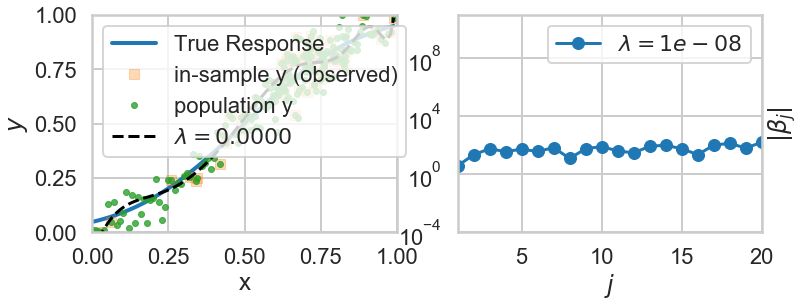

In [46]:
# code provided from here on
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
left = 0
right = 1

axs[left].plot(x,f, lw=4, label='True Response')
axs[left].plot(xtrain, ytrain, 's', alpha=0.3, ms=10, label="in-sample y (observed)")
axs[left].plot(x, y, '.', alpha=0.8, label="population y")
axs[left].plot(grid_to_predict, ypredict_ridge_best, 'k--', label=r"$\lambda =  {{{0:1.4f}}}$".format(best_lambda))
axs[left].set_ylabel('$y$')
axs[left].set_ylim((0, 1))
axs[left].set_xlim((0, 1))
axs[left].legend(loc=2)
coef = est.coef_.ravel()
axs[right].semilogy(np.abs(coef), marker='o', label=r"$\lambda =  {0}$".format(best_lambda))
axs[right].set_ylim((1e-04, 1.0e+11))
axs[right].set_xlim(1, 20)
axs[right].yaxis.set_label_position("right")
axs[right].set_ylabel(r'$\left|\beta_{j}\right|$')
axs[right].legend(loc='best')
axs[left].set_xlabel("x")
axs[right].set_xlabel(r'$j$');

## BONUS EXERCISE:

### The Titanic dataset

The `titanic.csv` file contains data for 887 passengers on the Titanic. Each row represents one person. The columns describe different attributes about the person including whether they survived, their age, their on-board class, their sex, and the fare they paid.

<div class="exercise"><b>Exercise</b></div>

1. Load in the data. 
2. Drop the following features:
'embarked', 'who', 'adult_male', 'embark_town', 'alive', 'alone'
3. Find for how many passengeres we do not have their deck information.
4. Count all the infants and toddlers on board (age less than 3) and all the children ages 3-10.
5. (*challenge*) Plot the distribution of ages, with bins color coded based on age: i. infants and toddlers (<3), ii. children (3-10), iii. preteens and teens (11-17), and iv. adults (18+).
6. Plot the distribution of fare paid by passengers with a [kernel density estimate](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.kde.html) overlayed on top of the histogram.
7. Perform some EDA to explore the associations of all the remaining variables with the response `survived` (use tables and plots).  Which variables appear to be most predictive of survival?
8. Fit a logistic regression to predict survival based on age alone.  Interpret the coefficient estimates of the model.
9. What is the predicted probability of survival for a 20 year old?  For a 50 year old?  
10. Fit a logistic regression model to predict survival based on all the other variables in the data set using [statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.html).  What factors are most important in the context of this model?  Do these match what you expected from the EDA?
11. For the model in the previous part, identify 4 observations: the persons with the highest and lowest probabilities of survival, and the persons with the most extreme (both negative and positive) errors in prediction.  
12. Create a X design matrix that includes all the 2-way interactions among the predictors.
13. Fit a logistic regression model to predict survival from the X design matrix in the previous part.  Do the interaction terms add anyn extra predictive power?  Which interaction term seems most important?
14. For the 4 observations identified in part 11, have things changed or improved?  Investigate why this is the case (using the model estimates can help with this step).


